In [38]:
%reload_ext autoreload
%autoreload 2
import os
import numpy as np
import jax.numpy as jnp
import jax.scipy as jsp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from IPython.display import display
from ipywidgets import widgets, interactive

from scipy.io import mmread

from typing import List

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# @title Download data if not exist (takes a while)
from util import download_all_data_if_not_exist, unzip

download_all_data_if_not_exist('https://ftp.ncbi.nlm.nih.gov/geo/series/GSE156nnn/GSE156455/suppl', './datasets/gziped',filter=lambda file: file.endswith('.gz'))
unzip('./datasets/gziped/', './datasets')

In [28]:
# @title Load data (takes a while)
data_dir = "./datasets"
data_type = "early"

def show_widget_datatype_select():
  dropdown = widgets.Dropdown(options=["early", "main"], value="early", description="dataset:")

  def on_value_change(t: str):
    global data_type 
    data_type = t

  interactive(on_value_change, t=dropdown)
  display(dropdown)

show_widget_datatype_select()

Dropdown(description='dataset:', options=('early', 'main'), value='early')

In [40]:
path = lambda filename: os.path.join(data_dir, filename)

matrix_src = path(f"GSE156455_matrix_{data_type}.mtx")
feature_src = path(f"GSE156455_features_{data_type}.tsv")
barcode_src = path(f"GSE156455_barcodes_{data_type}.tsv")
metadata_src = path(f"GSE156455_metadata_{data_type}.tsv")
tsne_src = path(f"GSE156455_tsne_{data_type}.tsv")

# read in MEX format matrix as table
mat = mmread(matrix_src)

# feature_id:   transcript ids, e.g. 'FBgn0038498'
# feature_name: gene names,     e.g. 'beat-IIa'
# feature_type: feature types,  e.g. 'Gene Expression'
feature_df = pd.read_table(feature_src, names=['feature_id', 'feature_name', 'feature_type'])

# barcode:      cell ids        e.g. 'DGRP_All_A_2_TGATTTCGTCATCCGG'
barcode_df = pd.read_table(barcode_src, names=['barcode'])

# barcode:      cellID
# set:          W1118 or DGRP datasets
# rep:          biological replicate (A/B)
# trep:         technical replicate (i.e. a single 10X library, see sampleID format below)
# genotype:     W1118 or DGRP strain (based on demultiplexing)
# time:         timepoint
# class:        cell class
# type:         cell type or cluster identity
# subtype:      cell subtype (if not applicable, same as type)
metadata_df = pd.read_table(metadata_src)

# barcode:      cellID
# tsne_1:       tSNE 1
# tsne_2:       tSNE 2
tsne_df = pd.read_table(tsne_src)

matrix = pd.DataFrame.sparse.from_spmatrix(mat, columns=barcode_df.barcode)
data = pd.concat([feature_df, matrix], axis=1)
data.set_index("feature_id", inplace=True)
data.head()

,feature_name,feature_type,DGRP_All_A_2_TGATTTCGTCATCCGG,DGRP_All_A_1_AGTCACATCGTAACAC,DGRP_All_A_5_AGGAAATAGCGTGAGT,DGRP_All_A_5_TGCTTCGCAAAGCGTG,DGRP_All_A_3_ATGGGAGAGAGCCTGA,DGRP_All_A_2_ATTTCACAGTCTGGAG,DGRP_All_A_8_AGGGCCTAGGCACGAT,DGRP_All_A_5_CTGGTCTGTGGACAGT,...,DGRP_All_B_1_GGTCACGGTACATACC,DGRP_All_B_7_GGCTGTGTCAGAATAG,DGRP_All_B_5_GGATGTTCATTATGCG,DGRP_All_B_7_GTTCGCTGTAATTGGA,DGRP_All_B_4_TCATCCGTCATGAGTC,DGRP_All_B_8_TTTGTTGAGGCTCAAG,DGRP_All_B_7_CTACGGGCACCTGATA,DGRP_All_B_4_AAGTCGTAGAAACCAT,DGRP_All_B_3_TTCCTTCAGCAGGGAG,DGRP_All_B_6_ACAAAGAAGGTCGACA
feature_id,,,,,,,,,,,,,,,,,,,,,
FBgn0031081,Nep3,Gene Expression,2,0,0,1,0,3,0,1,...,1,1,0,0,0,0,0,0,0,1
FBgn0052826,tRNA:Pro-CGG-1-1,Gene Expression,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FBgn0031085,CG9570,Gene Expression,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FBgn0062565,Or19b,Gene Expression,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FBgn0031088,CG15322,Gene Expression,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
feature_by_cell = data.drop(['feature_name', 'feature_type'], axis=1)
feature_by_cell['DGRP_All_A_2_TGATTTCGTCATCCGG']
cell_by_feature = feature_by_cell.T

In [43]:
tsne_with_metadata = pd.merge(tsne_df, metadata_df, on='barcode')

types = tsne_with_metadata['type'].unique()

centers = tsne_with_metadata.groupby('type').mean()[['tSNE_1', 'tSNE_2']]
centers.head()

,tSNE_1,tSNE_2
type,,
C112,-12.897756,-28.735564
C130,-20.814333,-45.849193
C46,-6.027915,-24.286069
C68,-25.076970,-28.820736
Dm10,-59.238391,-1.803554


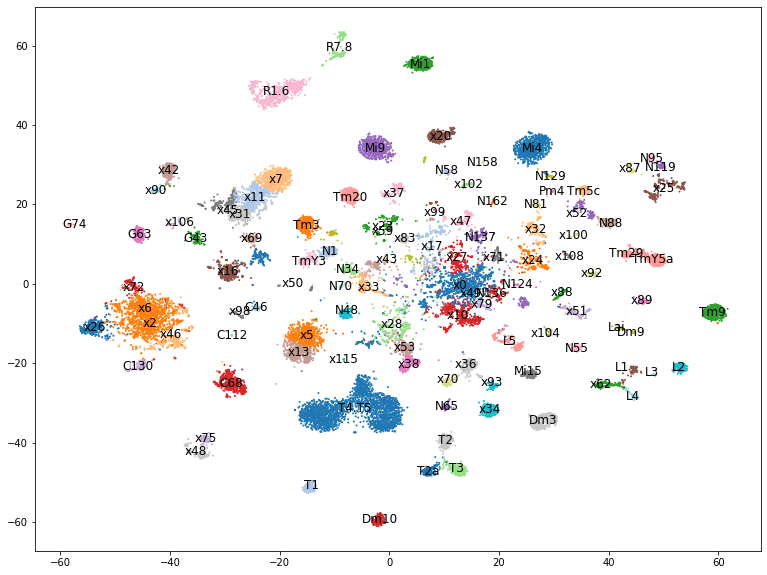

In [9]:
# @title Plot tSNE
fig = plt.figure(figsize=(13, 10))
ax = fig.add_subplot(111)

cmap = cm.get_cmap('tab20', len(types))
cdict = {t: cmap(i) for i, t in enumerate(types)}
c = [cdict[t] for t in tsne_with_metadata['type']]

ax.scatter(tsne_with_metadata['tSNE_2'], tsne_with_metadata['tSNE_1'], s=1, c=c)
for t, (tsne1, tsne2) in centers.iterrows():
    ax.annotate(t, (tsne2, tsne1), ha='center', va='center', fontsize=12)

/var/folders/w7/rrcz7y056_q_zqnsld3kmr580000gn/T/ipykernel_25526/1389003199.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expressions[col] = np.log2(1 + expressions[col] / expressions[col].max())


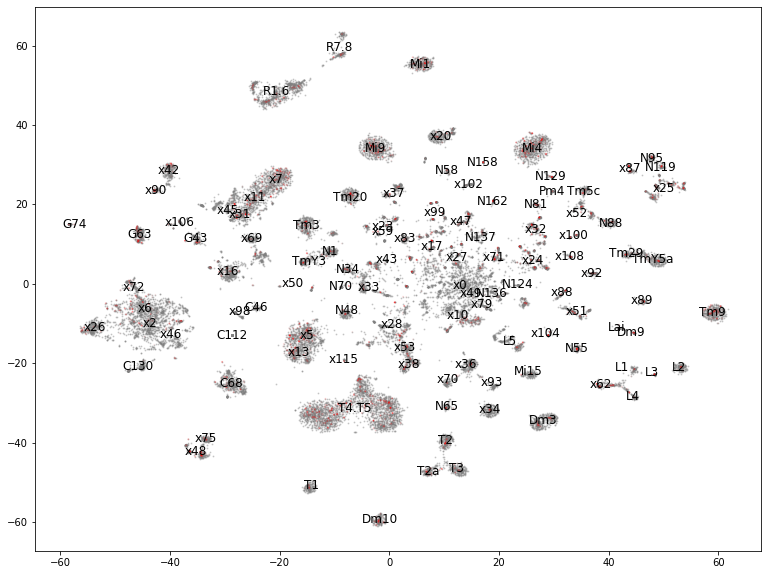

In [48]:
feature_ids: List[str] = ["FBgn0038498"]
time: List[str] = ["12h"]

fig = plt.figure(figsize=(13, 10))
ax = fig.add_subplot(111)

expressions = cell_by_feature[feature_ids]
for col in expressions.columns:
    # workaround
    expressions[col] = np.log2(1 + expressions[col] / expressions[col].max())

# base plot
ax.scatter(tsne_with_metadata['tSNE_2'], tsne_with_metadata['tSNE_1'], s=1, c='gray', alpha=0.3)
for t, (tsne1, tsne2) in centers.iterrows():
    ax.annotate(t, (tsne2, tsne1), ha='center', va='center', fontsize=12)

tsne_with_metadata_and_expression = pd.merge(tsne_with_metadata, expressions, left_on='barcode', right_index=True)

filtered = tsne_with_metadata_and_expression[tsne_with_metadata_and_expression[feature_id] > 0]
filtered = tsne_with_metadata_and_expression[tsne_with_metadata_and_expression['time'].isin(time)]
ax.scatter(filtered['tSNE_2'], filtered['tSNE_1'], s=1, c='red', alpha=tsne_with_metadata_and_expression[feature_id])

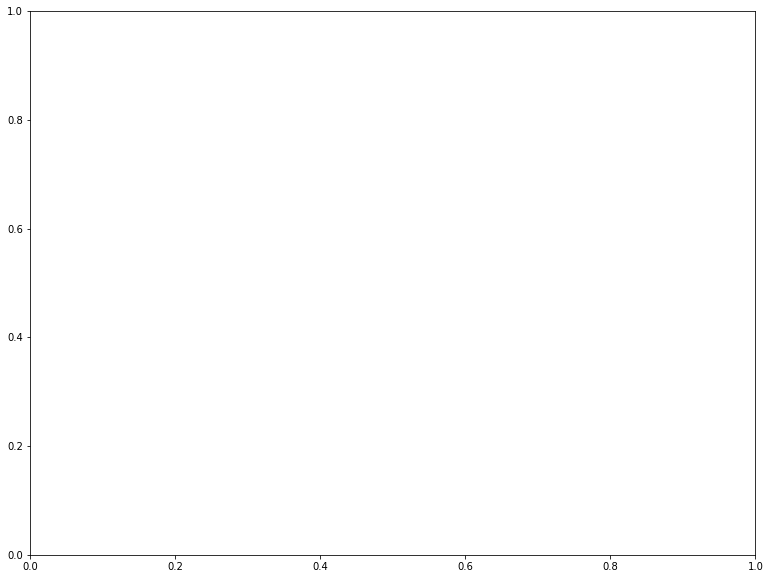

In [50]:
## WIP
def show_widget_filtered_plot():
    multiple1 = widgets.SelectMultiple(options=feature_df["feature_id"].unique(), value=["FBgn0038498"], description="gene:")
    multiple2 = widgets.Dropdown(options=["0h", "12h", "24h"], value="12h", description="time:")

    def show_plot(feature_ids: List[str], time: List[str]):
        fig = plt.figure(figsize=(13, 10))
        ax = fig.add_subplot(111)

        expressions = cell_by_feature[feature_ids]
        for col in expressions.columns:
            # workaround
            expressions[col] = np.log2(1 + expressions[col] / expressions[col].max())

        # base plot
        ax.scatter(tsne_with_metadata['tSNE_2'], tsne_with_metadata['tSNE_1'], s=1, c='gray', alpha=0.3)
        for t, (tsne1, tsne2) in centers.iterrows():
            ax.annotate(t, (tsne2, tsne1), ha='center', va='center', fontsize=12)

        tsne_with_metadata_and_expression = pd.merge(tsne_with_metadata, expressions, left_on='barcode', right_index=True)

        cmap = cm.get_cmap('tab20', len(feature_ids))
        for i, feature_id in enumerate(feature_ids):
            filtered = tsne_with_metadata_and_expression[tsne_with_metadata_and_expression[feature_id] > 0]
            filtered = tsne_with_metadata_and_expression[tsne_with_metadata_and_expression['time'].isin(time)]
            ax.scatter(filtered['tSNE_2'], filtered['tSNE_1'], s=1, c=cmap(i), alpha=tsne_with_metadata_and_expression[feature_id])

    interactive(show_plot, feature_ids=multiple1, time=multiple2)
    display(multiple1, multiple2);

show_widget_filtered_plot()

In [29]:
feature_by_cell.head()

,DGRP_All_A_2_TGATTTCGTCATCCGG,DGRP_All_A_1_AGTCACATCGTAACAC,DGRP_All_A_5_AGGAAATAGCGTGAGT,DGRP_All_A_5_TGCTTCGCAAAGCGTG,DGRP_All_A_3_ATGGGAGAGAGCCTGA,DGRP_All_A_2_ATTTCACAGTCTGGAG,DGRP_All_A_8_AGGGCCTAGGCACGAT,DGRP_All_A_5_CTGGTCTGTGGACAGT,DGRP_All_A_1_ATTTCACCAAGTGCAG,DGRP_All_A_2_AAGCGTTCAAGCCTGC,...,DGRP_All_B_1_GGTCACGGTACATACC,DGRP_All_B_7_GGCTGTGTCAGAATAG,DGRP_All_B_5_GGATGTTCATTATGCG,DGRP_All_B_7_GTTCGCTGTAATTGGA,DGRP_All_B_4_TCATCCGTCATGAGTC,DGRP_All_B_8_TTTGTTGAGGCTCAAG,DGRP_All_B_7_CTACGGGCACCTGATA,DGRP_All_B_4_AAGTCGTAGAAACCAT,DGRP_All_B_3_TTCCTTCAGCAGGGAG,DGRP_All_B_6_ACAAAGAAGGTCGACA
feature_id,,,,,,,,,,,,,,,,,,,,,
FBgn0031081,2,0,0,1,0,3,0,1,1,0,...,1,1,0,0,0,0,0,0,0,1
FBgn0052826,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FBgn0031085,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FBgn0062565,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FBgn0031088,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
metadata_df.head()

,barcode,set,rep,trep,genotype,time,class,type,subtype
0,DGRP_All_A_2_TGATTTCGTCATCCGG,DGRP,A,2,line_897,0h,x,x0,x0
1,DGRP_All_A_1_AGTCACATCGTAACAC,DGRP,A,1,line_850,0h,x,x26,x26
2,DGRP_All_A_5_AGGAAATAGCGTGAGT,DGRP,A,5,line_850,0h,N,Mi4,Mi4
3,DGRP_All_A_5_TGCTTCGCAAAGCGTG,DGRP,A,5,line_850,0h,x,x50,x50
4,DGRP_All_A_3_ATGGGAGAGAGCCTGA,DGRP,A,3,line_805,0h,N,T2a,T2a


111


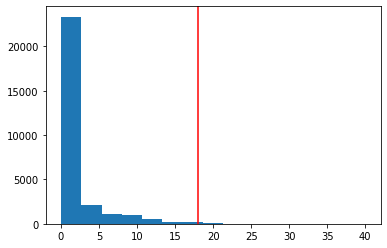

In [6]:
# @title Parameters
threshold_of_expression = 18
feature_id = "FBgn0038498"

print(np.count_nonzero([cell_by_feature[feature_id] > threshold_of_expression]))

fig = plt.figure()
ax = fig.add_subplot(111)
K = int(1 + np.log2(len(cell_by_feature[feature_id])))
ax.hist(cell_by_feature[feature_id], bins=K)
ax.vlines(threshold_of_expression, 0, 1, colors='red', transform=ax.get_xaxis_transform());

In [7]:
# get all cells which have a feature expression above the threshold
cell_ids = cell_by_feature[feature_id][cell_by_feature[feature_id] > threshold_of_expression].index
# get all features expressed with the specified feature in each above cells
genes = {cell_id: feature_by_cell[cell_id][feature_by_cell[cell_id] > 0] for cell_id in cell_ids}

In [8]:
coexpressions = pd.concat(genes, axis=1)
# coexpressions = pd.concat((data["feature_name"], coexpressions), axis=1)
coexpressions

,DGRP_All_A_8_GTCTGTCTCCTAGCCT,DGRP_All_A_1_AAGCGAGTCGTCTCAC,DGRP_All_A_2_TGGGATTTCAGATTGC,DGRP_All_B_5_CCCTGATCAGCGATTT,DGRP_All_B_7_ATCACTTCAGAGGTAC,DGRP_All_A_2_CAGCGTGCAATTGCAC,DGRP_All_A_3_GTTAGACAGAAATGGG,DGRP_All_A_8_GTGAGGAGTTCCAGGC,DGRP_All_A_2_TGCACGGCAGCAATTC,DGRP_All_A_6_CCTCAACGTTATCTTC,...,DGRP_All_B_7_CATAGACTCTCGCCTA,DGRP_All_B_6_TACCGGGCACACCGCA,DGRP_All_B_6_GTTTGGAGTAACTGCT,DGRP_All_B_7_AGAAATGCATCAGCGC,DGRP_All_B_2_CCCTTAGAGGGCAAGG,DGRP_All_B_5_CATGCTCAGTCAGCGA,DGRP_All_B_7_GGAATCTTCTCCAATT,DGRP_All_B_6_ACTTTGTAGCCACAAG,DGRP_All_B_7_CTCATGCTCCAACCGG,DGRP_All_B_3_GCCAACGTCTACCAGA
feature_id,,,,,,,,,,,,,,,,,,,,,
FBgn0031081,3.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0
FBgn0053217,2.0,1.0,NaN,NaN,2.0,NaN,1.0,NaN,1.0,1.0,...,1.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN
FBgn0052350,2.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN
FBgn0024733,55.0,39.0,11.0,14.0,77.0,15.0,6.0,41.0,6.0,47.0,...,22.0,17.0,15.0,18.0,38.0,23.0,22.0,21.0,15.0,43.0
FBgn0040372,1.0,NaN,1.0,2.0,NaN,NaN,NaN,NaN,1.0,1.0,...,1.0,NaN,NaN,1.0,NaN,2.0,2.0,1.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FBgn0033459,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
FBgn0002564,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
FBgn0263453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [9]:
# @title Linear regression
X = np.nan_to_num(coexpressions.drop(feature_id, axis=0).T.values)
y = np.nan_to_num(np.array(coexpressions.T[feature_id].values))

theta = np.linalg.pinv(X) @ y

In [10]:

np.count_nonzero(theta>0.05)

14

54


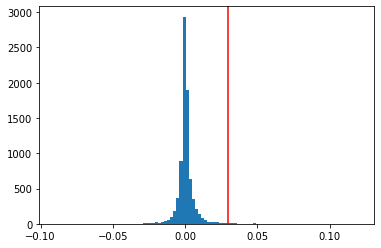

In [11]:
threshold_of_weight = 0.03

print(np.count_nonzero(theta > threshold_of_weight))

fig = plt.figure()
ax = fig.add_subplot(111)
K = 100
ax.hist(theta, bins=K)
ax.vlines(threshold_of_weight, 0, 1, colors='r', transform=ax.get_xaxis_transform());

In [12]:
other_features = coexpressions.drop(feature_id, axis=0).index
feature_ids = np.array(other_features[theta > threshold_of_weight]) #type: ignore
len(feature_ids)

54

In [13]:
for_join = pd.DataFrame({"feature_id": other_features, "theta": theta})

In [14]:
feature_df_with_theta = feature_df.join(for_join.set_index("feature_id"), on="feature_id")
feature_df_with_theta[feature_df_with_theta['feature_id'].isin(feature_ids)].sort_values(by='theta', ascending=False)

,feature_id,feature_name,feature_type,theta
5572,FBgn0004198,ct,Gene Expression,0.120342
9642,FBgn0259213,side-II,Gene Expression,0.104105
1431,FBgn0029123,SoxN,Gene Expression,0.086310
1137,FBgn0001942,eIF4A,Gene Expression,0.071601
2448,FBgn0032946,nrv3,Gene Expression,0.071168
16854,FBgn0011817,nmo,Gene Expression,0.070359
6075,FBgn0003274,RpLP2,Gene Expression,0.065826
6558,FBgn0000253,Cam,Gene Expression,0.065398
12155,FBgn0265296,Dscam2,Gene Expression,0.060269
4816,FBgn0002626,RpL32,Gene Expression,0.057639
